# Semi-structured NN 
## ISIC archive 2020 melanoma dataset
https://challenge2020.isic-archive.com/

In [1]:
!conda list --explicit > spec-file.txt
#conda create -n bfvi --file spec-file.txt

In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow import keras
import seaborn as sns
import tensorflow.keras
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from numpy import load

2022-08-18 13:36:27.577265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
%reload_ext autoreload
%autoreload 2
from functions.scoreCI import score_ci, score_stat_ci
from functions.vimlts import VimltsLinear
from functions.sample_bernoulli_nll import sample_bernoulli_nll

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score

print("Tensorflow version:", tf.__version__)

2022-08-18 13:36:29.107650: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-18 13:36:29.110571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-18 13:36:29.162208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 13:36:29.162341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.605GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-18 13:36:29.162359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:36:29.177112: I tensorflow/stream_executor/platfor

Tensorflow version: 2.4.1


dynamic library libcudnn.so.7
2022-08-18 13:36:29.237971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 13:36:29.238075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 13:36:29.238142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2022-08-18 13:36:29.238364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:36:29.898028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-18 13:36:29.898048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-08-18 13:36:29.898053:

## Import data

- Original image dataset resized to 128,128
- Tabular data: Only using patiens age as predictor

In [4]:
## add resize images and add path to patient
dat = pd.read_csv('data/ISIC_2020_Training_GroundTruth.csv')
train_dir = "data/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"

## Data preparation 


Missing values

In [5]:
### missing values Age
dat['age_approx'].isnull().sum()

68

In [6]:
###fill missing value age with mean value
dat['age_approx'] = dat['age_approx'].fillna(dat['age_approx'].mean())
dat['age_approx'].isnull().values.any()

False

80% training set, 20% of training set used for validation set, 20% test set

In [7]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)


train_idx = idx[:int(len(dat)*0.8)] 
test_idx = idx[int(len(dat)*0.8):] 
valid_idx = train_idx[:int(len(train_idx)*0.2)] 
train_idx = train_idx[int(len(train_idx)*0.2):]

X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]

X_trainAge = dat.iloc[train_idx]
X_trainAge = X_train.loc[:, X_train.columns.intersection(['age_approx'])]
X_validAge= dat.iloc[valid_idx]
X_validAge = X_valid.loc[:, X_train.columns.intersection(['age_approx'])]
X_testAge= dat.iloc[test_idx]
X_testAge = X_test.loc[:, X_train.columns.intersection(['age_approx'])]

print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


## Standardize tabular data

In [8]:
def standard(data):
    mean = np.mean(data)
    std = np.std(data)
    standard = (data - mean) / std
    return standard

In [9]:
standAgeTr = standard(X_trainAge)
standAgeVal = standard(X_validAge)
standAgeTe= standard(X_testAge)

## Image data preprocessing

In [10]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array 
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_valid

test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape,
      '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


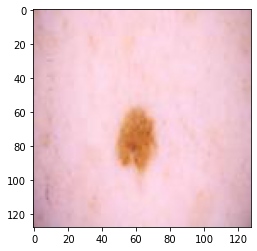

In [11]:
#scale pixel between 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")

train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

plt.imshow(train_imgs_scaled[10])

### Functions 

In [12]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)

def logScore(y_obs, y_pred):
    likelihoodElements= (y_obs*np.log(y_pred) + (1 - y_obs)*np.log(1 - y_pred))
    nll = np.mean(likelihoodElements)
    return print (nll.values[0])

### Parameters

In [13]:
opt = RMSprop()
batch_size=256
num_samples = 1000    ##approximate expected value
M=50 ##degree of bernsteinpolynom
prior_dist=tfd.Normal(loc=0.,scale=1.)  ##prior normal distributed

## CNN without TM-VI

### Training with 3 Runs

In [14]:
def mymodel(X):
    initializer = keras.initializers.HeNormal(seed = 2802)
    
    in_ = keras.Input(shape = X.shape[1:], name = "inImg")

    x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
    x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    
    out_ = layers.Dense(1, activation = "sigmoid")(x) 
    
    imageMod = Model(in_, out_)
    return imageMod

In [15]:
# define model and compile
# Needed to be run in three goes (out-of-memory running the third time)
for i in range(3):
    model = mymodel(train_imgs_scaled)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'RMSprop',
                  metrics = ['AUC'])
    

    
    # train
    results = model.fit(x=train_imgs_scaled,
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 50,
                        verbose= True,
                       )   
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['val_auc'], 
                        'test_loss': results.history['val_loss'], 'test_acc': results.history['val_auc']})
    dat.to_csv('cnn/run' + str(i) + 'history.csv', index=False)
    pred = model.predict(test_imgs_scaled)
    out = pd.DataFrame(pred, columns = ['p_0'])
    out.to_csv('cnn/run' + str(i) + 'test_predictions.csv', index=False)

2022-08-18 13:36:47.084799: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4168089600 exceeds 10% of free system memory.
2022-08-18 13:36:48.284209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-18 13:36:48.306005: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/50


2022-08-18 13:36:49.538775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-18 13:36:49.739752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-18 13:36:50.507347: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-18 13:36:50.679779: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


83/83 [==============================] - 79s 592ms/step - loss: 0.7492 - auc: 0.4980 - val_loss: 0.2603 - val_auc: 0.4501
Epoch 2/50
83/83 [==============================] - 7s 88ms/step - loss: 0.2624 - auc: 0.5310 - val_loss: 0.0953 - val_auc: 0.6272
Epoch 3/50
83/83 [==============================] - 7s 88ms/step - loss: 0.1151 - auc: 0.5527 - val_loss: 0.0875 - val_auc: 0.6831
Epoch 4/50
83/83 [==============================] - 7s 87ms/step - loss: 0.0936 - auc: 0.6403 - val_loss: 0.0880 - val_auc: 0.6865
Epoch 5/50
83/83 [==============================] - 7s 87ms/step - loss: 0.0991 - auc: 0.6729 - val_loss: 0.0899 - val_auc: 0.6478
Epoch 6/50
83/83 [==============================] - 7s 88ms/step - loss: 0.0938 - auc: 0.6798 - val_loss: 0.0896 - val_auc: 0.6813
Epoch 7/50
83/83 [==============================] - 7s 89ms/step - loss: 0.0929 - auc: 0.6726 - val_loss: 0.0856 - val_auc: 0.7103
Epoch 8/50
83/83 [==============================] - 7s 89ms/step - loss: 0.0925 - auc: 0.669

FileNotFoundError: [Errno 2] No such file or directory: 'run2cnn/history.csv'

In [20]:
predrun0 = pd.read_csv('cnn/run0test_predictions.csv')
p0= predrun0.values
predrun1 = pd.read_csv('cnn/run1test_predictions.csv')
p1= predrun1.values
predrun2 = pd.read_csv('cnn/run2test_predictions.csv')
p2= predrun2.values

### Performance Log-Score & AUC

In [21]:
### average predictions
meanPreds= [(g + h + u) / 3 for g, h,u in zip(p0, p1,p2)]
meanpreds = pd.DataFrame(meanPreds, columns = ['meanPreds'])

###Log-Score
logscore= logScore(test_labels, meanpreds.values)


###AUC
meanPredsAuc= meanpreds.values.ravel()
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanPredsAuc, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

-0.07641193625783675
AUC=0.83, 95% CI: 0.79-0.86


### Loss curves

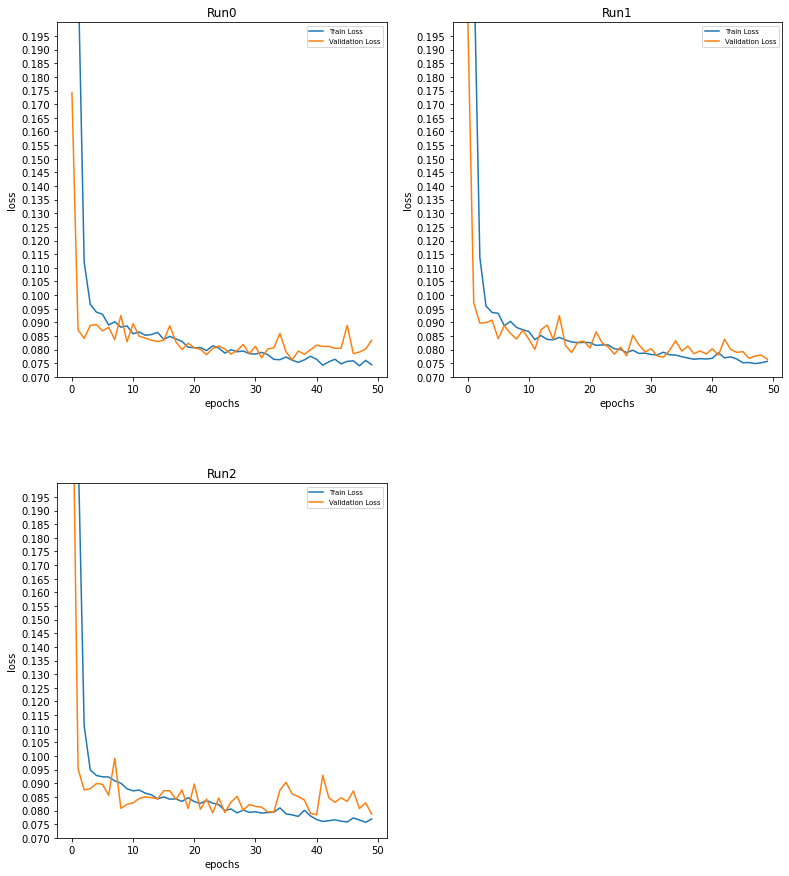

In [25]:
loss_0 = pd.read_csv('cnn/run0history.csv')
loss_1 = pd.read_csv('cnn/run1history.csv')
loss_2 = pd.read_csv('cnn/run2history.csv')

plt.figure(figsize=(13,15))
plt.subplot(221)
plt.plot(loss_0['train_loss'],label="Train Loss")
plt.plot(loss_0['test_loss'], label="Validation Loss")
plt.legend()
plt.title("Run0")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.2)
plt.yticks(np.arange(0.07, 0.2, 0.005))
plt.legend(fontsize='x-small')
plt.subplot(222)
plt.plot(loss_1['train_loss'],label="Train Loss")
plt.plot(loss_1['test_loss'], label="Validation Loss")
plt.legend()
plt.title("Run1")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.2)
plt.yticks(np.arange(0.07, 0.2, 0.005))
plt.legend(fontsize='x-small')
plt.subplots_adjust( hspace=0.3)
plt.subplot(223)

plt.plot(loss_2['train_loss'],label="Train Loss")
plt.plot(loss_2['test_loss'], label="Validation Loss")
plt.title("Run2")
plt.legend()
plt.ylim(0.07,0.2)
plt.yticks(np.arange(0.07, 0.2, 0.005))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')
#plt.savefig("LossCurves3Runs")

## CNN + Tabular TM-VI

In [26]:
initializer = keras.initializers.HeNormal(seed = 2802)
    
inImg = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(inImg)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
    
eta = layers.Dense(1, activation = "linear")(x) 
    
out = K.expand_dims(eta, axis=0)
outr = tf.keras.backend.repeat_elements(out,1000,axis=0)


nn_img = Model(inImg, outr)


In [27]:
### Linear shift tabular TM-VI method


theta_start = -1
theta_stop = 1
delta_theta = softplus_inv((theta_stop-theta_start)/(M))
vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] 
                               + [initializers.Constant(delta_theta) for _ in range(M)])



inCov = keras.Input(shape = 1, name = 'inCov')
outCov = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=num_samples,
                      size = standAgeTr.shape[0],
                      **vimlts_initializers,
                      prior_dist=prior_dist)(inCov)

nn_tab = keras.Model(inputs = inCov, outputs = outCov)
nn_tab.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inCov (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
vimlts_linear (VimltsLinear) (1000, None, 1)           55        
Total params: 55
Trainable params: 55
Non-trainable p

In [28]:
def combinedModel(X, X_meta):
    added = tf.keras.layers.Add()([X_meta.output, X.output]) 
    out = tf.math.sigmoid(added)   ##transformation to probabilities
    model = keras.Model(inputs = [X_meta.input, X.input], outputs = out, name='model_2')
    return model

model = combinedModel(nn_tab, nn_img)
model.compile(loss=sample_bernoulli_nll, optimizer=opt,run_eagerly=False,metrics=[sample_bernoulli_nll])

In [31]:
results = model.fit(x=[train_imgs_scaled, standAgeTr],
                     y = train_labels,
                     validation_data = ([validation_imgs_scaled, standAgeVal], val_labels),
                     batch_size=batch_size,
                     epochs = 14,
                     verbose= False) 

2022-08-18 14:02:15.947064: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4168089600 exceeds 10% of free system memory.


In [36]:
# save history
dat = pd.DataFrame({'train_loss': results.history['loss'], 
                        'val_loss': results.history['val_loss']})
dat.to_csv('M3/history_combinded.csv', index=False)

In [37]:
### save model weights
model.save_weights("models/CNN+MFBFTabular", save_format ="tf")

In [38]:
### recreate Model
model.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
#model.fit(x =[train_imgs_scaled,standAgeTr],y = train_labels, verbose=True)
### load the state of the old model
model.load_weights("models/CNN+MFBFTabular")

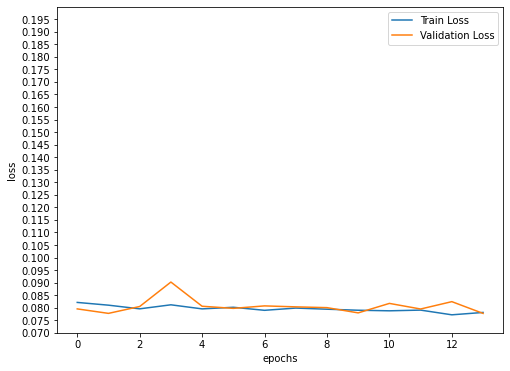

In [39]:
loss = pd.read_csv('M3/history_combinded.csv')
plt.figure(figsize=(8,6))

plt.plot(loss['train_loss'],label="Train Loss")
plt.plot(loss['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.2)
plt.yticks(np.arange(0.07, 0.2, 0.005))
plt.legend()

## Posterior parameter $\beta_\text{Age}$ from tabular NN

Text(0, 0.5, '$p(\\beta_1|D)$')

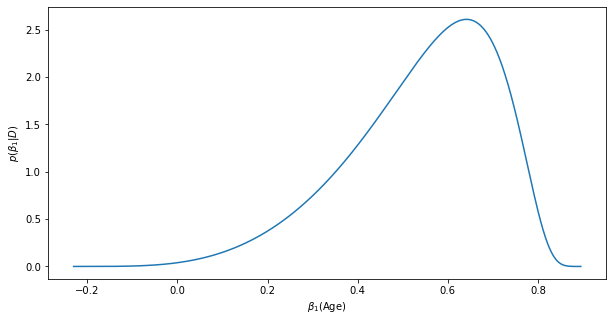

In [40]:
plt.figure(figsize=(10,5))
### get slope parameter from tabular model 
layer = nn_tab.layers[1]
qw, w = layer.get_w_dist()
plt.plot(w, qw, linewidth=1.5)
plt.xlabel("$\\beta_1$(Age)")
plt.ylabel("$p(\\beta_1|D)$")
plt.xlabel("$\\beta_1$(Age)")
plt.ylabel("$p(\\beta_1|D)$")

In [45]:
m1 = pd.DataFrame(list(zip(w, qw)),columns=['slope_weight',"slope_density"])
m1.to_csv("semi_posterior_slope_age.csv", index=False)

## Performance NLL & AUC

In [42]:
### performance
xtest = [test_imgs_scaled, standAgeTe]
y_pred = model.predict(xtest,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

2022-08-18 14:05:45.299472: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [43]:
logloss = logScore(test_labels,predictions)

-0.07612947881727078


In [44]:
###AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)


AUC=0.82, 95% CI: 0.79-0.85
